In [28]:
#!pip install opencv-python
#!pip install opencv-contrib-python

#!pip install -U opencv-python
#!apt update && apt install -y libsm6 libxext6 ffmpeg libfontconfig1 libxrender1 libgl1-mesa-glx

#!pip install pandas
#!pip install -U scikit-learn scipy matplotlib
#!pip install tqdm
#!pip install shutup

In [138]:
import os
import cv2
import time
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html
def load_image_by_path(file_path,img_weight,img_height):
    image= cv2.imread(file_path)
    image= cv2.resize(src=image,dsize=(img_weight, img_height),interpolation=cv2.INTER_CUBIC)
    # convert from BGR to RGB without alpha channel
    #image= image[:, :, 0:1]
    image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def load_images_by(path_list,img_weight,img_height,log_info):
    img_list=[]
    for path in tqdm(path_list,log_info):
        img= load_image_by_path(path,img_weight,img_height)
        img_list.append(img)
    return np.array(img_list)

def plot_predict_vs_test (input_img,output_img,required_output_img):
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(input_img)
    ax[0].set_title('input_img')
    ax[1].imshow(output_img)
    ax[1].set_title('output_img')
    if required_output_img is not None:
        ax[2].imshow(required_output_img)
        ax[2].set_title('required_output_img')
    plt.show()

def current_milli_time():
    return round(time.time() * 1000)

In [139]:
# docker exec -it dc9c bash

import warnings
import shutup;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


DATASET_ROOT_DIR = "/tf/notebooks/AiLearning/DataSetStore/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img"


IMG_SIZE = 128
EXP_SIZE = 400
TEST_SIZE = 0.25
BATCH_SIZE = 50
NN_EPOCH = 1500
ENCODER_FILE_NAME_MODEL = "./encoder_{}x{}x{}x{}x{}".format(IMG_SIZE,EXP_SIZE,TEST_SIZE,BATCH_SIZE,NN_EPOCH)

img_subfolder = "images"
mask_subfolder = "masks"

img_path = os.path.join(DATASET_ROOT_DIR,img_subfolder)
mask_path = os.path.join(DATASET_ROOT_DIR,mask_subfolder)
img_name_list = os.listdir(img_path)
mask_name_list = os.listdir(mask_path)

shutup.please()
image_array = load_images_by([os.path.join(img_path,img_name) for img_name in img_name_list],
                             IMG_SIZE, IMG_SIZE, img_subfolder)
shutup.please()
mask_array = load_images_by([os.path.join(mask_path,msk_name) for msk_name in mask_name_list],
                            IMG_SIZE, IMG_SIZE, mask_subfolder)

# Selecting not full dataset
image_array = image_array[0:EXP_SIZE]
mask_array = mask_array[0:EXP_SIZE]



images:   0%|          | 0/1192 [00:00<?, ?it/s]

masks:   0%|          | 0/1192 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

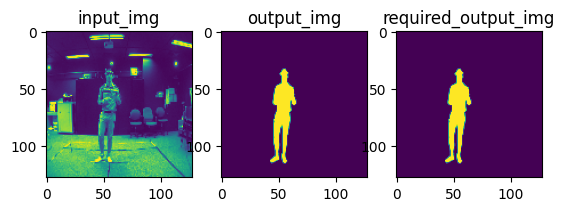

In [140]:
number =1
plot_predict_vs_test(image_array[number],mask_array[number],mask_array[number])


image size= (400, 128, 128, 1)
mask size= (400, 128, 128, 1)


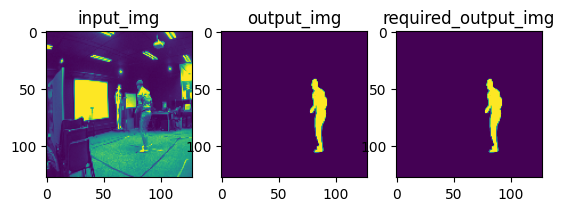

In [141]:
image_array = image_array/255
mask_array = mask_array/255

image_array = image_array.reshape(image_array.shape[0],image_array.shape[1],image_array.shape[2],1)
mask_array = mask_array.reshape(mask_array.shape[0],mask_array.shape[1],mask_array.shape[2],1)

print ("image size=",image_array.shape)
print ("mask size=",mask_array.shape)
number =0
plot_predict_vs_test(image_array[number],mask_array[number],mask_array[number])

image train size= (300, 128, 128, 1)
mask train size= (300, 128, 128, 1)


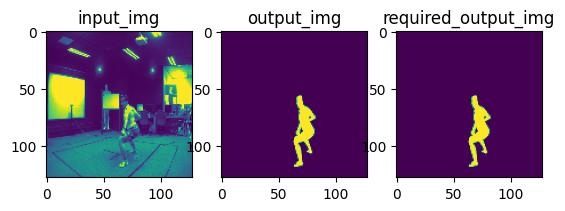

In [142]:
x_train, x_test, y_train, y_test = train_test_split(image_array, mask_array, test_size=TEST_SIZE, random_state=22)
print ("image train size=",x_train.shape)
print ("mask train size=",y_train.shape)
number =10
plot_predict_vs_test(image_array[number],mask_array[number],mask_array[number])

In [143]:
def encoder_layer(input_tensor,filters,kernel_size,up_or_down=True):
    if up_or_down == True:
        x = BatchNormalization()(input_tensor)
        # simple upsampling can be used instead. Strides coefficient mulitply the size
        x = Conv2DTranspose(filters,kernel_size,strides=(2,2),padding="same",activation="relu")(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters/2,kernel_size,padding="same",activation="relu")(x)
        return x
    else :
        x = Conv2D(filters,kernel_size,padding="same",activation="relu")(input_tensor)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        x = Conv2D(filters*2,kernel_size,padding="same",activation="relu")(x)
        x = BatchNormalization()(x)
        return x


In [144]:
#https://keras.io/examples/vision/oxford_pets_image_segmentation/

import keras

@keras.saving.register_keras_serializable(package="encoder_nn", name="dice_function")
def dice_function(y_true, y_pred):
    mul_sum = 2*tf.math.reduce_sum(y_true*y_pred)
    bas_sum = tf.math.reduce_sum(y_true)+tf.math.reduce_sum(y_pred)
    dice = mul_sum/bas_sum
    dice = 1.0-dice
    return dice

def encoder_nn():
    input = Input((IMG_SIZE,IMG_SIZE,1))
    x = encoder_layer(input,8,(9,9),False)
    x = encoder_layer(x,32,(5,5),False)
    x = encoder_layer(x,128,(3,3),False)

    x = encoder_layer(x,256,(3,3),True)
    x = encoder_layer(x,64,(5,5),True)
    x = encoder_layer(x,16,(9,9),True)
    x = Conv2D(1,(5,5),padding="same",activation="sigmoid")(x)
    
    encoder_model=Model(input,x)
    encoder_model.compile(optimizer=Adam(), loss=dice_function, metrics=['mean_squared_error'])
                         # loss='mean_squared_error')
                         # performance optimization for CPU is quite difficult to optimize
                         # jit_compile=True,run_eagerly=None,
                         #pss_evaluation_shards=7)
    return encoder_model


encoder = encoder_nn()
encoder.summary()



Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_360 (Conv2D)         (None, 128, 128, 8)       656       
                                                                 
 batch_normalization_432 (B  (None, 128, 128, 8)       32        
 atchNormalization)                                              
                                                                 
 max_pooling2d_108 (MaxPool  (None, 64, 64, 8)         0         
 ing2D)                                                          
                                                                 
 conv2d_361 (Conv2D)         (None, 64, 64, 16)        10384     
                                                                 
 batch_normalization_433 (B  (None, 64, 64, 16)        64 

In [145]:
hist = encoder.fit(x_train,y_train,epochs=NN_EPOCH,batch_size=BATCH_SIZE,validation_data=(x_test,y_test))


Epoch 1/1500
6/6 [==============================] - 48s 8s/step - loss: 0.8599 - mean_squared_error: 0.2625 - val_loss: 0.9205 - val_mean_squared_error: 0.2179
Epoch 2/1500
6/6 [==============================] - 45s 8s/step - loss: 0.6698 - mean_squared_error: 0.1032 - val_loss: 0.9270 - val_mean_squared_error: 0.1003
Epoch 3/1500
6/6 [==============================] - 45s 8s/step - loss: 0.4117 - mean_squared_error: 0.0289 - val_loss: 0.9429 - val_mean_squared_error: 0.0476
Epoch 4/1500
6/6 [==============================] - 45s 8s/step - loss: 0.2837 - mean_squared_error: 0.0201 - val_loss: 0.9586 - val_mean_squared_error: 0.0424
Epoch 5/1500
6/6 [==============================] - 45s 8s/step - loss: 0.2451 - mean_squared_error: 0.0179 - val_loss: 0.9109 - val_mean_squared_error: 0.0904
Epoch 6/1500
6/6 [==============================] - 45s 8s/step - loss: 0.2203 - mean_squared_error: 0.0161 - val_loss: 0.9081 - val_mean_squared_error: 0.1674
Epoch 7/1500
6/6 [======================

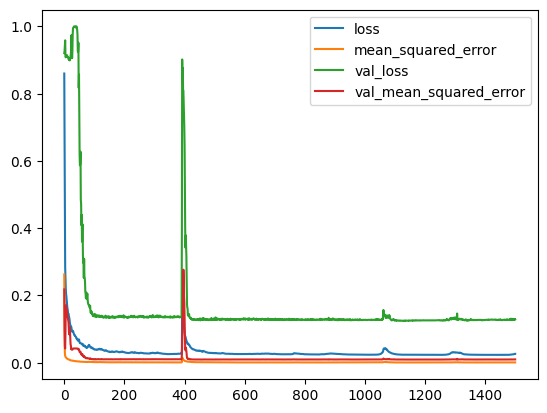

In [146]:
for key in hist.history.keys():
    plt.plot(hist.history[key],label=key)
plt.legend()
plt.show()

In [147]:


# Persisting the model params to file
file_name = "{}-{}.h5".format(ENCODER_FILE_NAME_MODEL,current_milli_time())
encoder.save(file_name)



4/4 [==============================] - 4s 770ms/step


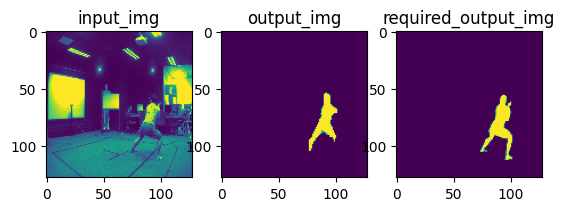

Dice coefficient = 0.7817258883248731


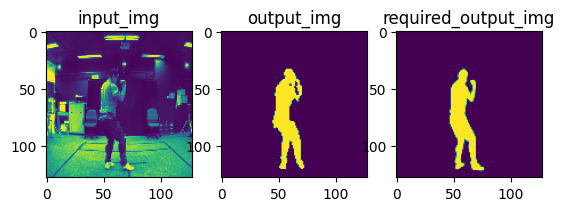

Dice coefficient = 0.8981255093724532


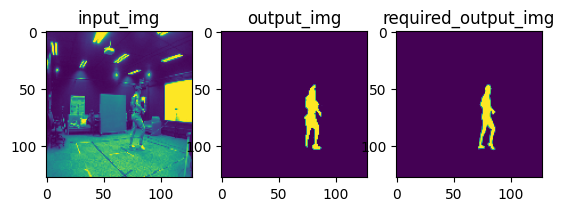

Dice coefficient = 0.8433734939759037


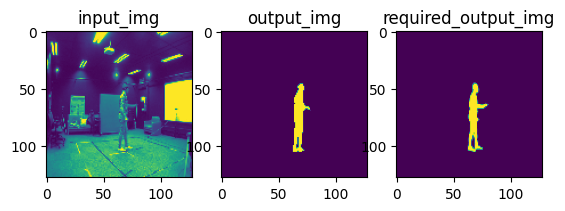

Dice coefficient = 0.8512195121951219


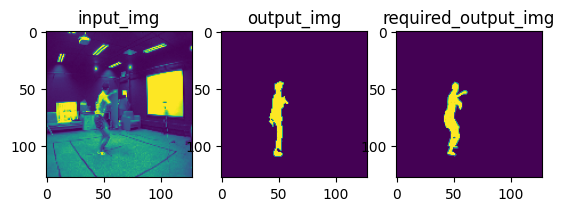

Dice coefficient = 0.7816326530612245


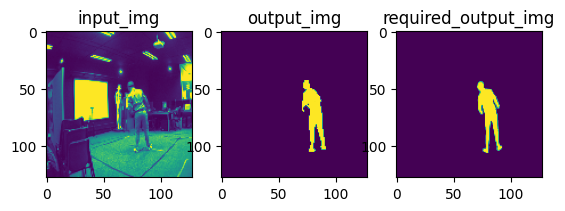

Dice coefficient = 0.8678304239401496


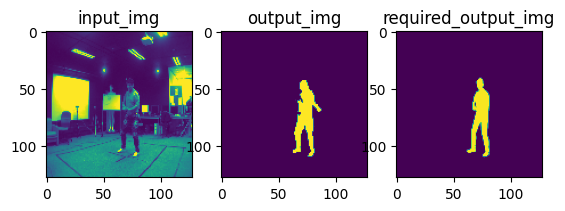

Dice coefficient = 0.8760932944606414


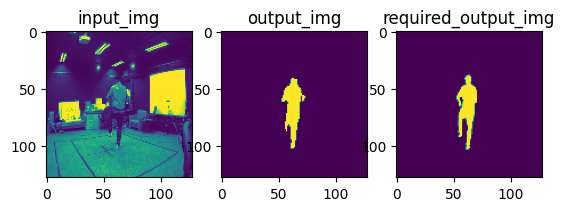

Dice coefficient = 0.8508474576271187


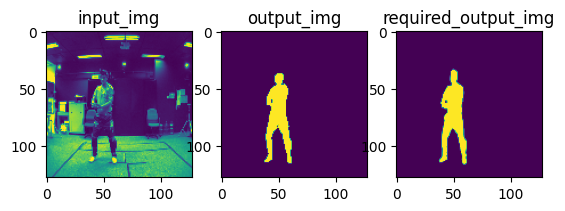

Dice coefficient = 0.934409687184662


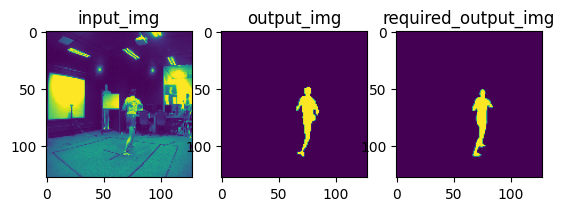

Dice coefficient = 0.7925840092699884


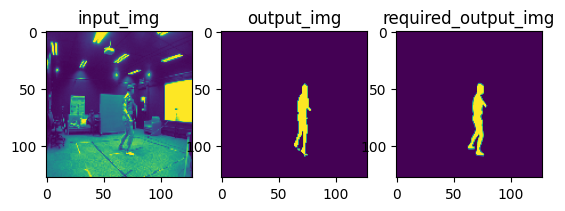

Dice coefficient = 0.8547815820543093


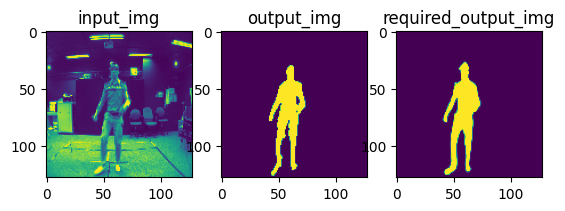

Dice coefficient = 0.912707182320442


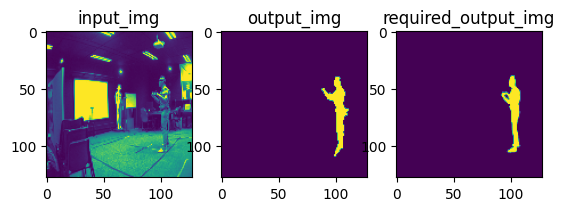

Dice coefficient = 0.8414376321353065


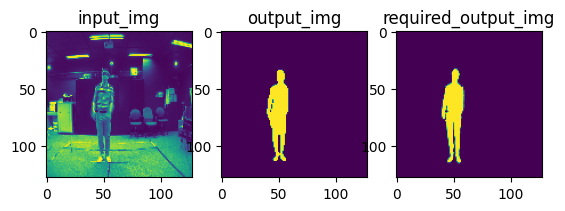

Dice coefficient = 0.9438943894389439


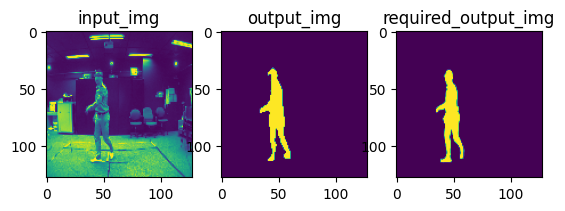

Dice coefficient = 0.9037864680322781


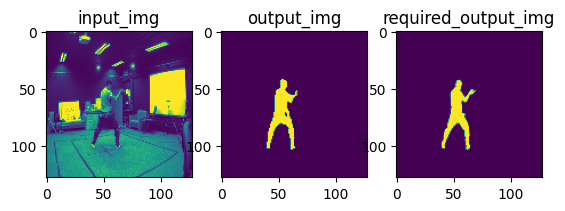

Dice coefficient = 0.8791565287915653


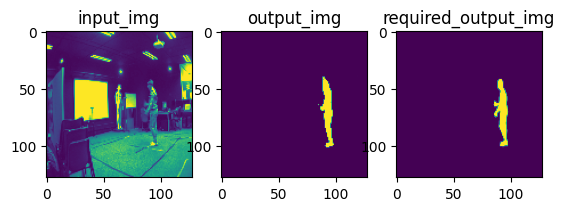

Dice coefficient = 0.8743016759776536


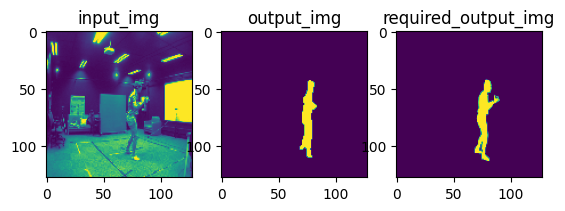

Dice coefficient = 0.8446215139442231


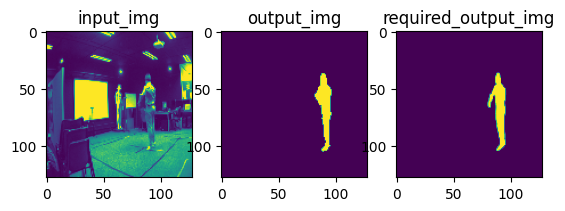

Dice coefficient = 0.8930041152263375


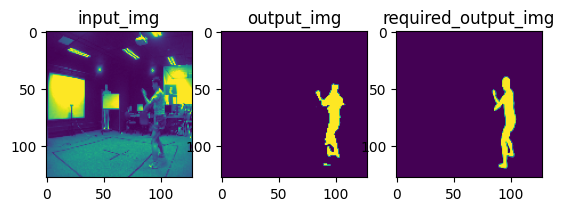

Dice coefficient = 0.7863777089783281


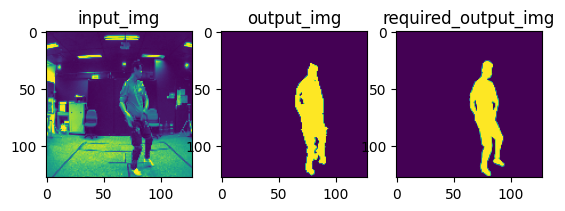

Dice coefficient = 0.8968698517298188


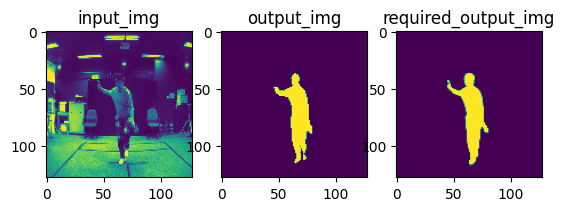

Dice coefficient = 0.9193391642371235


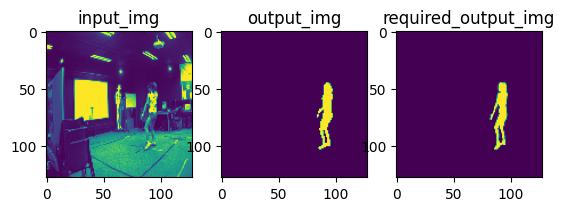

Dice coefficient = 0.8619854721549637


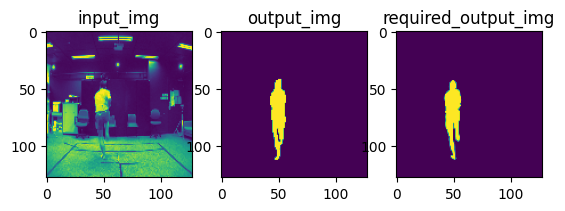

Dice coefficient = 0.9115417017691659


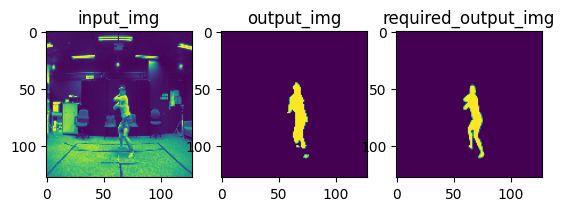

Dice coefficient = 0.8429423459244533


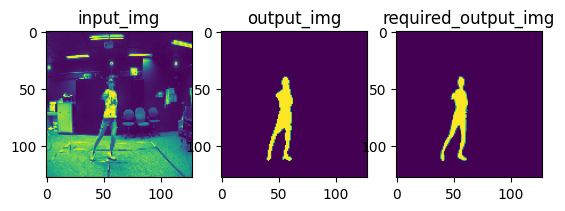

Dice coefficient = 0.881769641495042


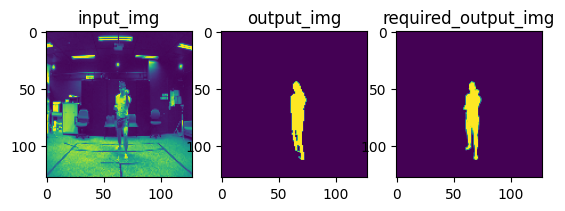

Dice coefficient = 0.8785211267605634


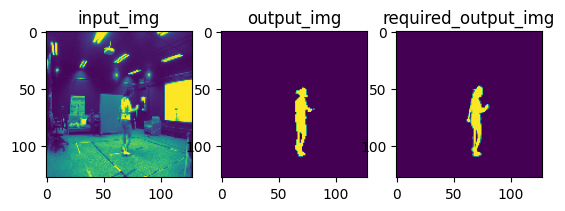

Dice coefficient = 0.8269858541893362


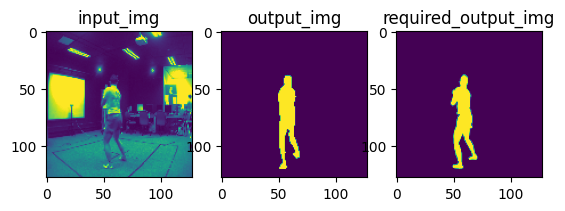

Dice coefficient = 0.8704908338261383


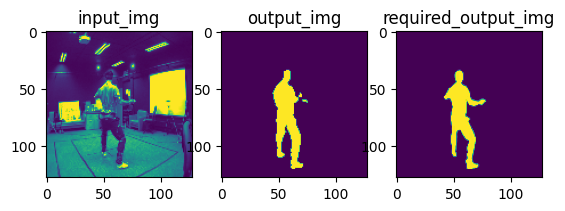

Dice coefficient = 0.8612099644128114


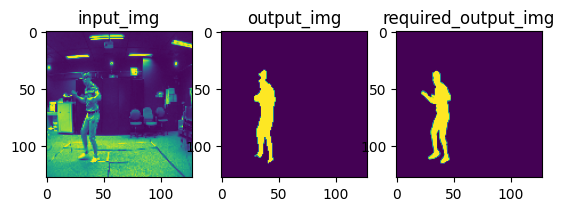

Dice coefficient = 0.8884913536076327


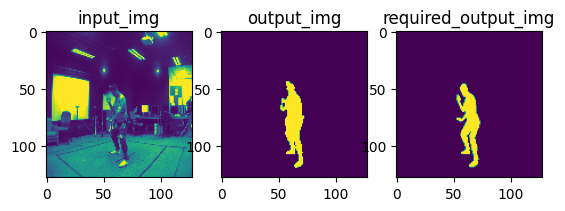

Dice coefficient = 0.8471047495120364


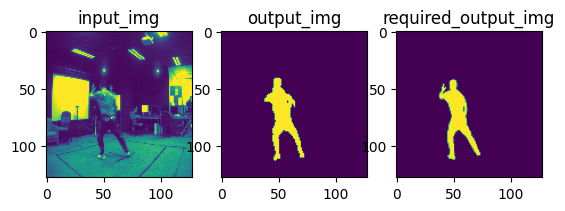

Dice coefficient = 0.8672959466962799


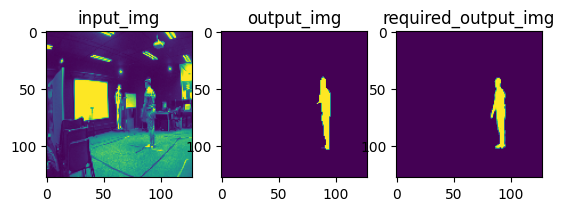

Dice coefficient = 0.8919597989949749


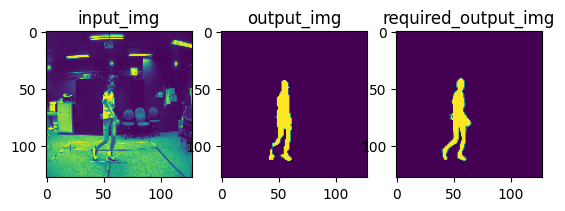

Dice coefficient = 0.868421052631579


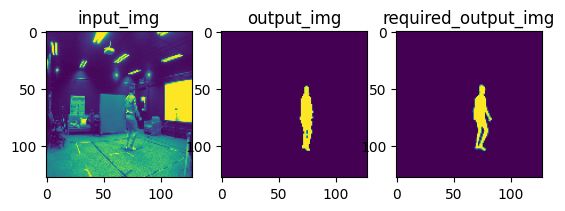

Dice coefficient = 0.8411214953271028


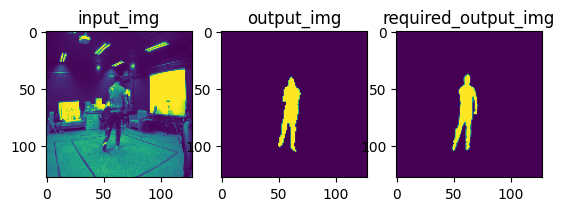

Dice coefficient = 0.8713029576338929


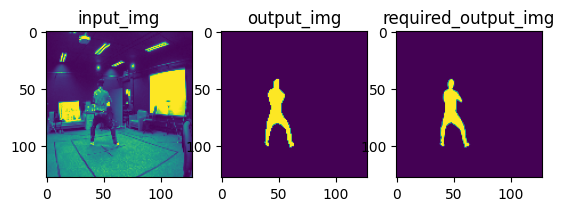

Dice coefficient = 0.9266136162687887


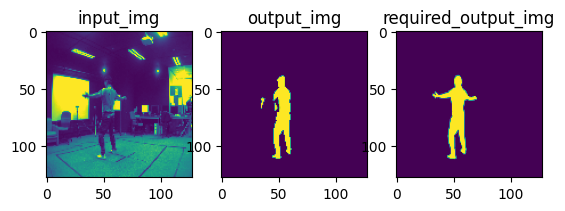

Dice coefficient = 0.8640522875816994


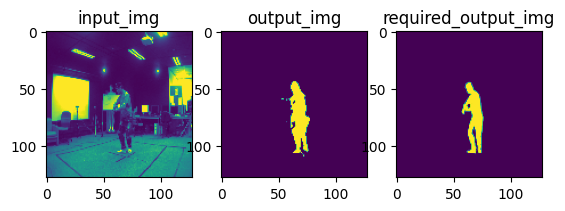

Dice coefficient = 0.8300079808459697


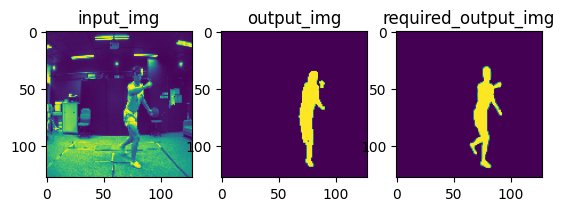

Dice coefficient = 0.8579610538373424


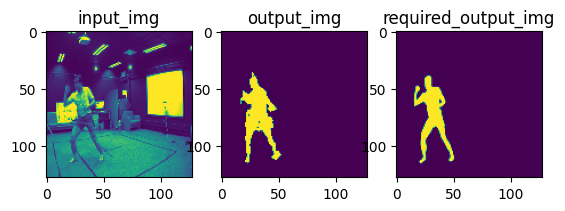

Dice coefficient = 0.806272129489125


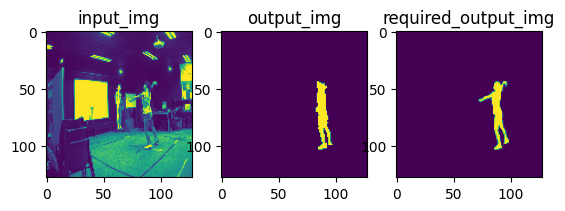

Dice coefficient = 0.7990487514863258


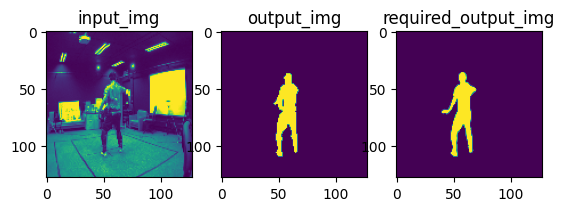

Dice coefficient = 0.9138134592680047


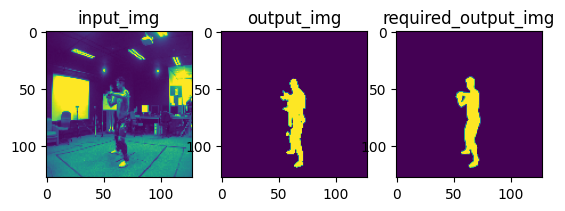

Dice coefficient = 0.8663819402074435


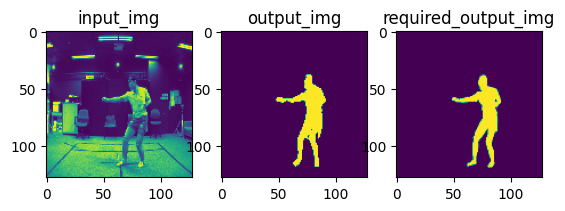

Dice coefficient = 0.9088385006941231


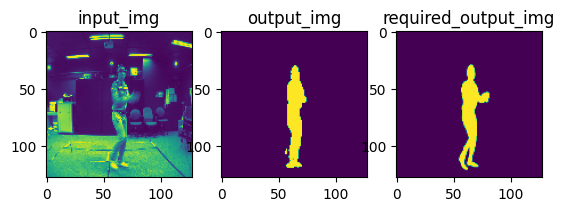

Dice coefficient = 0.8737558931377685


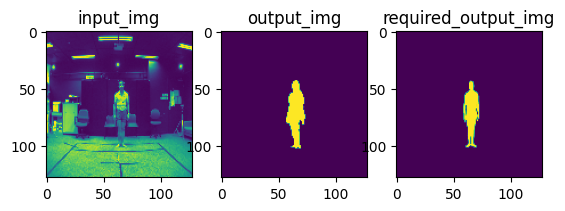

Dice coefficient = 0.8431183830606352


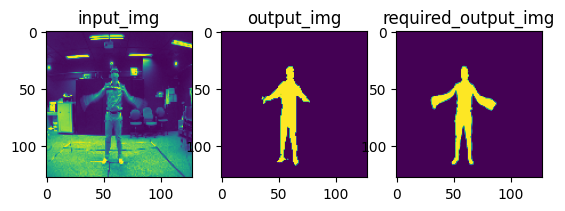

Dice coefficient = 0.8692547969656403


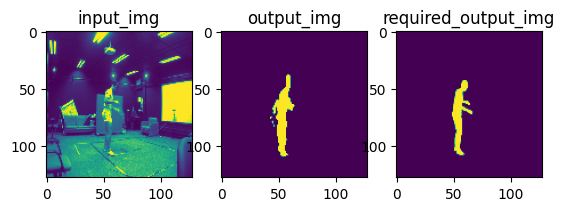

Dice coefficient = 0.7586206896551724


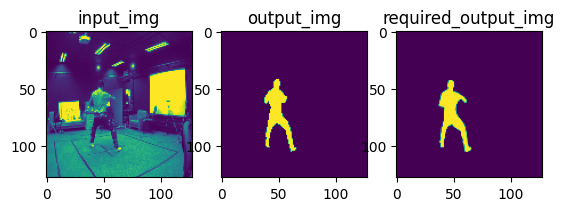

Dice coefficient = 0.9157894736842105


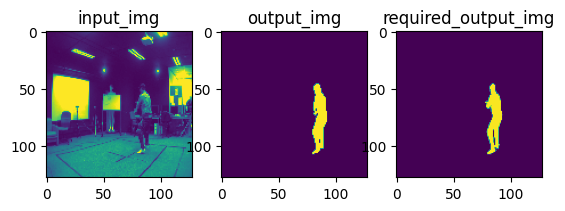

Dice coefficient = 0.92


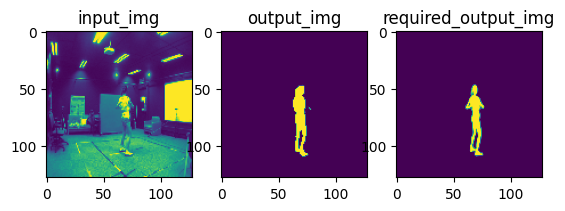

Dice coefficient = 0.8293241695303551


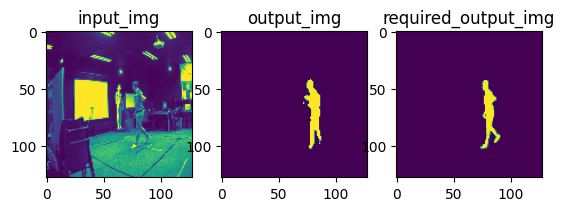

Dice coefficient = 0.801920768307323


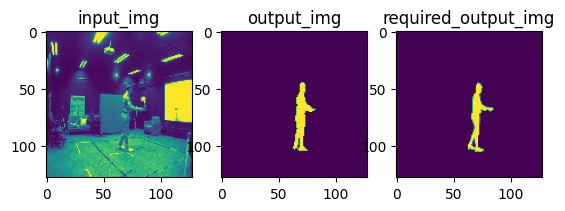

Dice coefficient = 0.8390129259694477


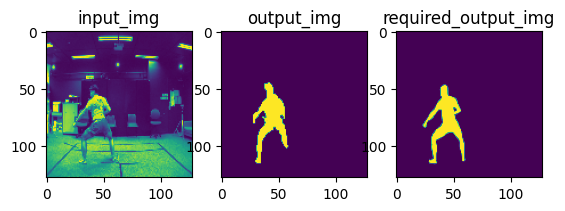

Dice coefficient = 0.85


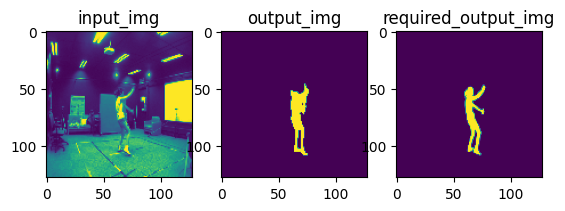

Dice coefficient = 0.7639751552795031


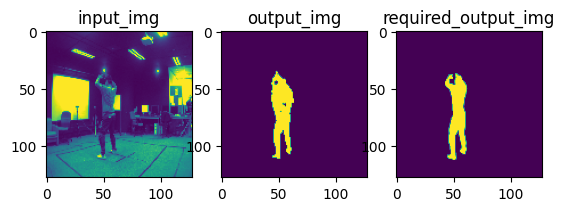

Dice coefficient = 0.8525345622119815


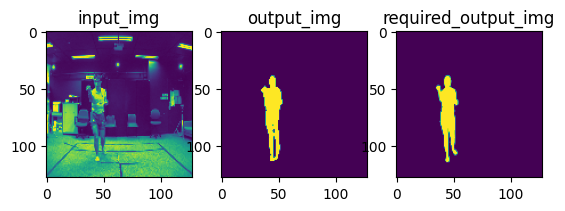

Dice coefficient = 0.911340206185567


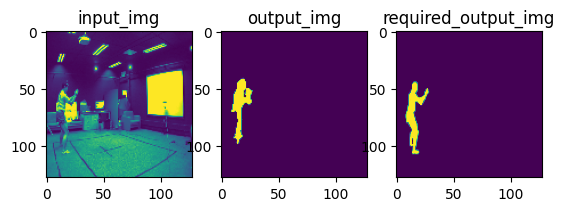

Dice coefficient = 0.6761229314420804


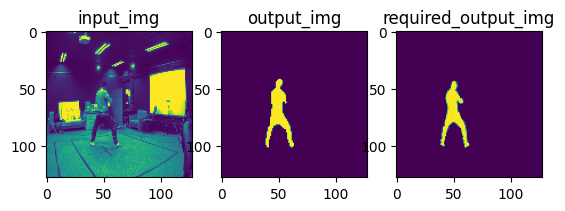

Dice coefficient = 0.9013035381750466


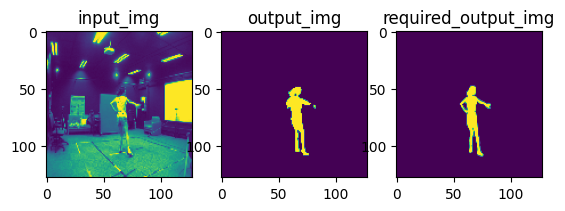

Dice coefficient = 0.8525252525252526


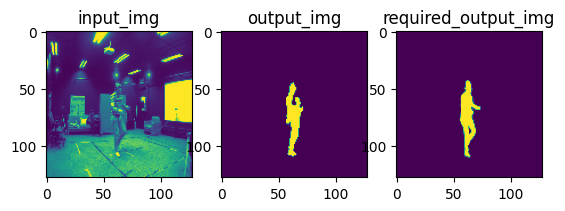

Dice coefficient = 0.8035714285714286


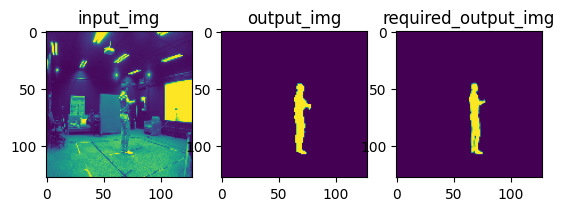

Dice coefficient = 0.8773903262092239


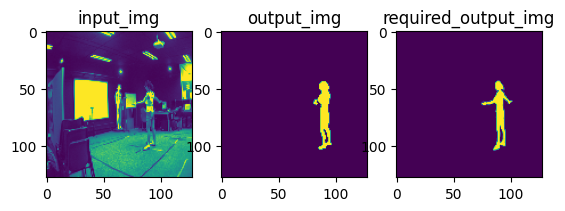

Dice coefficient = 0.8390129259694477


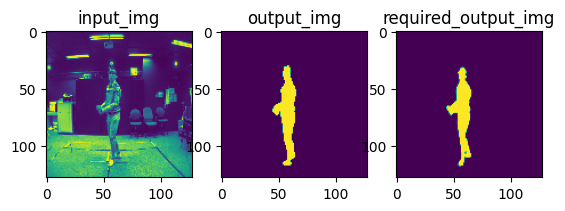

Dice coefficient = 0.921760391198044


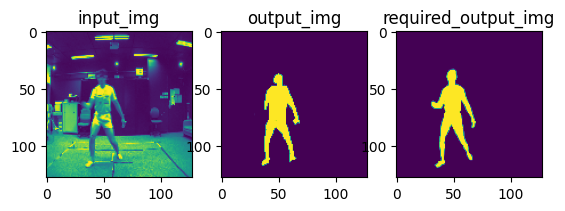

Dice coefficient = 0.884108867427568


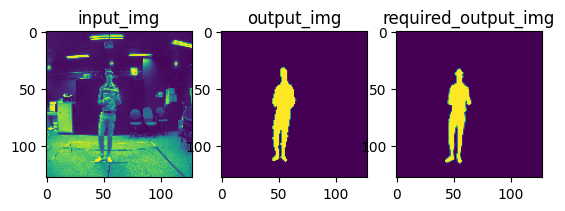

Dice coefficient = 0.9254385964912281


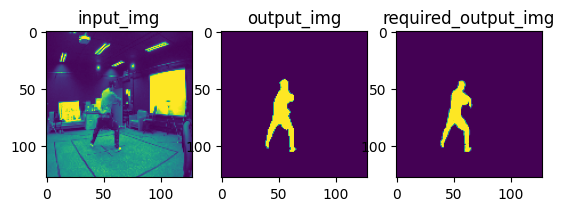

Dice coefficient = 0.8852459016393442


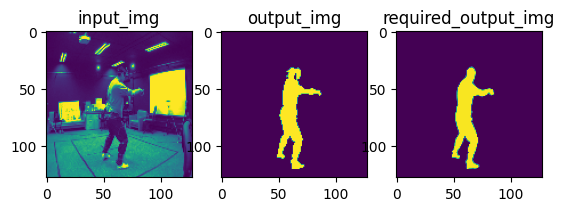

Dice coefficient = 0.9338454972257789


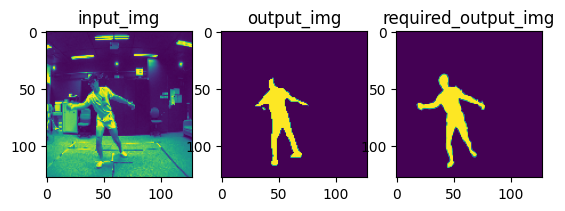

Dice coefficient = 0.8518173345759553


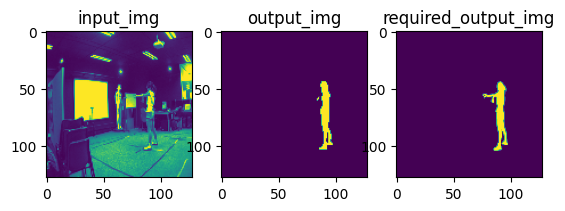

Dice coefficient = 0.8564036222509702


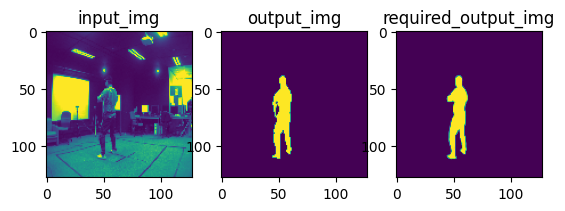

Dice coefficient = 0.9147920927062031


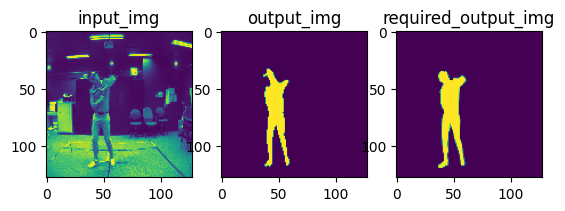

Dice coefficient = 0.913887506222001


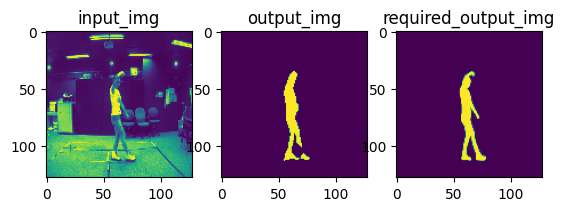

Dice coefficient = 0.8593508500772797


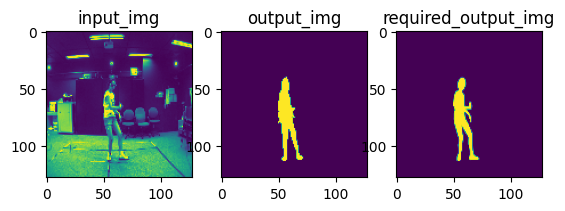

Dice coefficient = 0.8538638102524866


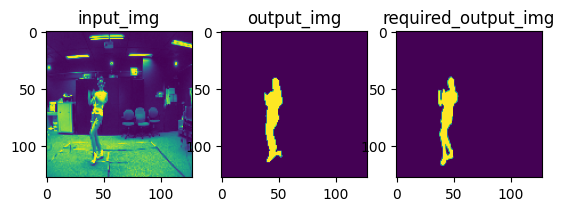

Dice coefficient = 0.8504672897196262


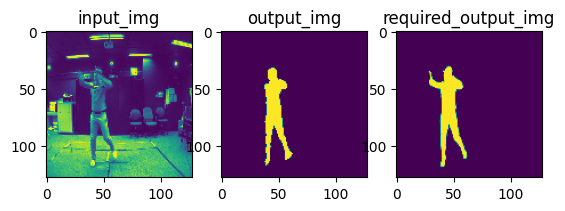

Dice coefficient = 0.9056603773584906


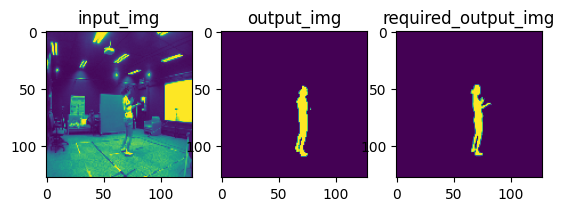

Dice coefficient = 0.8035043804755945


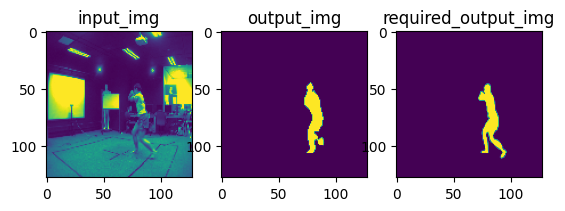

Dice coefficient = 0.7944700460829494


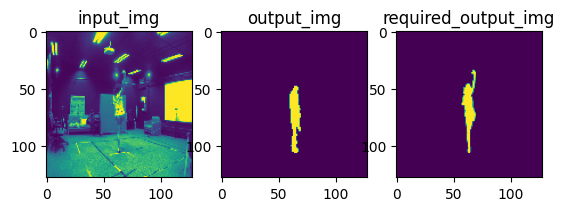

Dice coefficient = 0.772972972972973


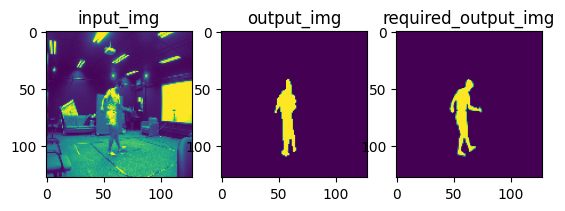

Dice coefficient = 0.8019169329073482


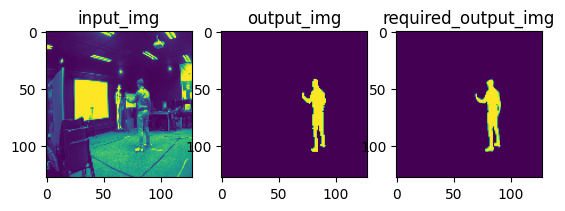

Dice coefficient = 0.9019248395967002


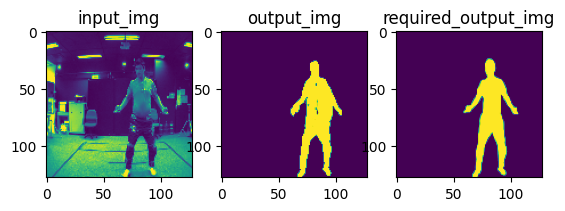

Dice coefficient = 0.9128233970753655


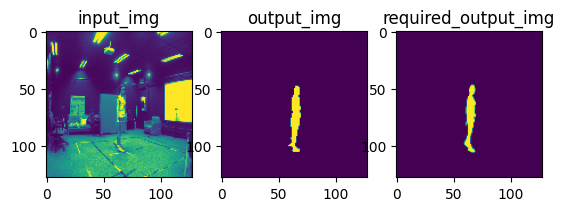

Dice coefficient = 0.8834355828220859


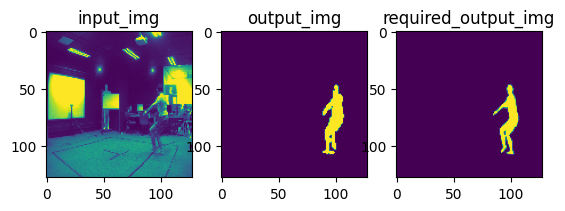

Dice coefficient = 0.7889207258834766


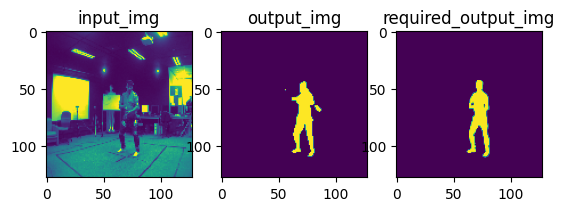

Dice coefficient = 0.8839541547277937


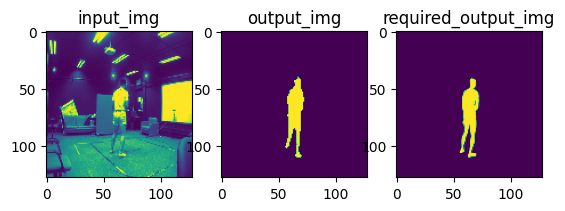

Dice coefficient = 0.9028475711892797


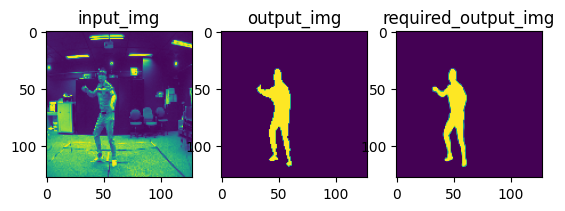

Dice coefficient = 0.926605504587156


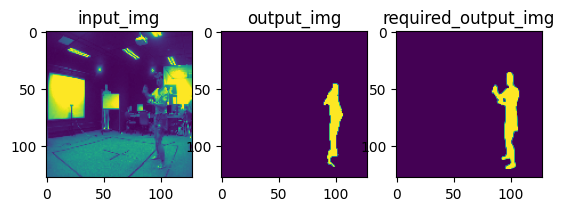

Dice coefficient = 0.736370425690814


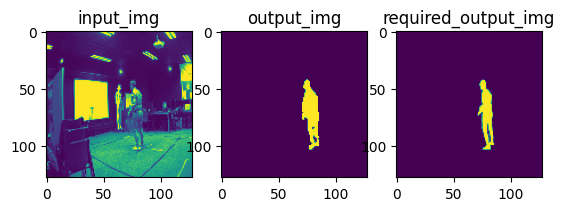

Dice coefficient = 0.8258706467661692


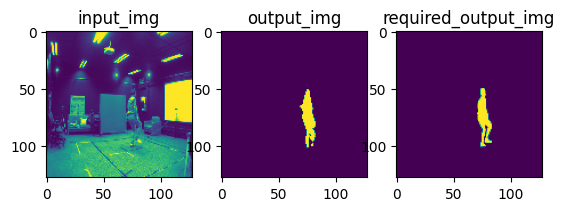

Dice coefficient = 0.8252569750367107


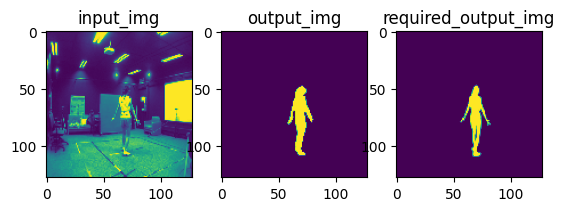

Dice coefficient = 0.8312439729990356


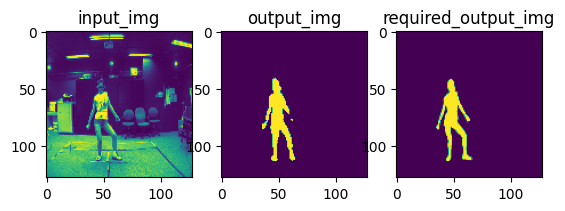

Dice coefficient = 0.8544973544973545


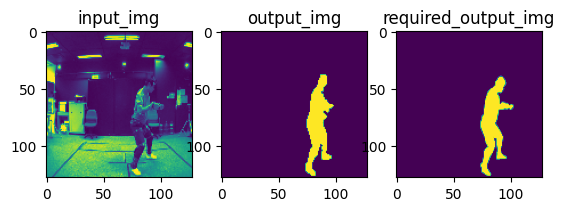

Dice coefficient = 0.8922184630256162


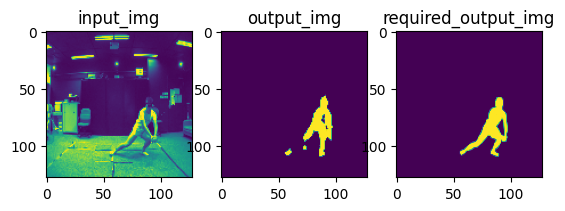

Dice coefficient = 0.7788461538461539


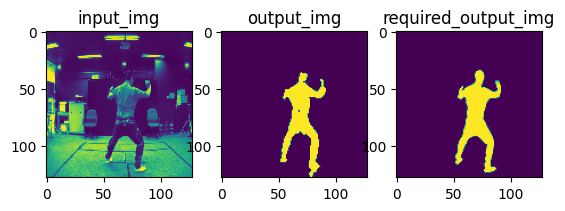

Dice coefficient = 0.8900218499635834


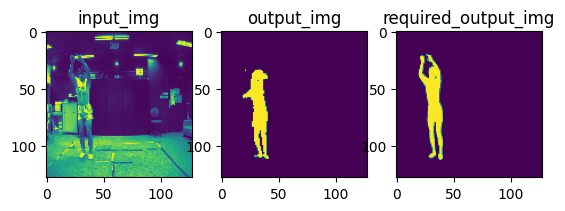

Dice coefficient = 0.8116279069767441


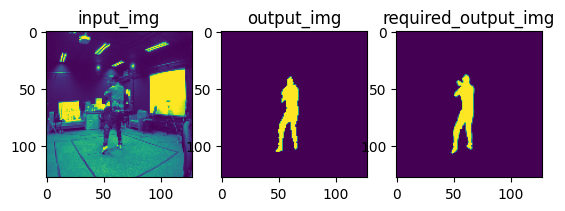

Dice coefficient = 0.903177004538578


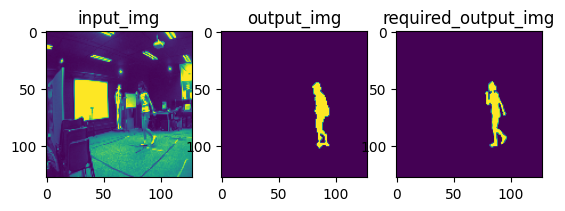

Dice coefficient = 0.7533414337788579


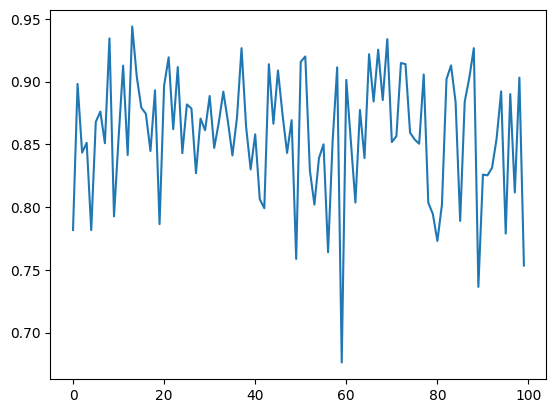

In [148]:

def threshold_dice(pred, test, threshold = 0.85):
    value_intersection = pred[test>=threshold];
    intersection = np.sum(value_intersection>=threshold) * 2.0
    dice = intersection / (np.sum(pred>=threshold) + np.sum(test>=threshold))
    return dice

tested_encoder = tf.keras.models.load_model(file_name)

y_pred = tested_encoder.predict(x_test)

dice_list=[]
for (input_img,output_img,required_output_img) in zip(x_test,y_pred,y_test):
    plot_predict_vs_test(input_img,output_img,required_output_img)
    dice_coef = threshold_dice(pred=output_img,test=required_output_img)
    print ("Dice coefficient = {}".format(dice_coef))
    dice_list.append(dice_coef)

plt.plot(dice_list,label="dice coefficients")



In [22]:
# https://docs.opencv.org/4.x/d9/df8/tutorial_root.html
# https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
# https://habr.com/ru/articles/485890/

# https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
# https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html
# https://pythonbook.site/python/python-progress-bars-with-tqdm
# https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset/
# https://www.kaggle.com/code/drmwnnrafi/full-body-segmentation-w-tf-u2net
# https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics